# SECTION 4 - PART 3: LLM ZERO-SHOT CLASSIFICATION

Sentiment Analysis - LLM – zero-shot: Try zero-shot classification using a (small) LLM model like tinyllama (1.1B) or qwen3:1.7b.

**Obiettivi:**
1. Configuring Ollama pipeline (es. TinyLlama, Qwen).
2. Claassify a reddit comment subset.
3. Comparing the results with VADER (baseline) and with manual label (ground truth).

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn tqdm ollama nltk

# Important OLLAMA:
# 1. Install
# 2. 'ollama serve'
# 3. 'ollama pull tinyllama'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from tqdm import tqdm
import time
import warnings
import ollama
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Verufy ollama connection
try:
    models = ollama.list()
    print(f"\nAvailable models: {[m['name'] for m in models.get('models', [])]}")
except Exception as e:
    print(f"\n⚠️ ERROR OLLAMA: {e}")
    print("Is 'ollama serve' executing on terminal?")


Available models: []


## 1. Loading and Sampling Data
Let's select a representative subset of comments from different subreddits to test the generalization capacity of the model.

In [3]:
df_supervised = pd.read_csv('../data/data_supervised.csv')

# stratified
np.random.seed(42)

top_subreddits = df_supervised['subreddit'].value_counts().head(10).index.tolist()
sample_dfs = []

for sub in top_subreddits:
    sub_df = df_supervised[df_supervised['subreddit'] == sub]
    if 'data_supervised.csv' in locals().get('df_supervised', ''):
         sub_df = sub_df[sub_df['body'].str.len().between(50, 500)]
    
    sample_size = min(5, len(sub_df))  # Let's sample 5 comments per sub to have better speed
    sample_dfs.append(sub_df.sample(n=sample_size, random_state=42))

df_sample = pd.concat(sample_dfs, ignore_index=True)
print(f"Totale commenti campionati: {len(df_sample)}")
df_sample.head()

Totale commenti campionati: 50


,author,subreddit,created_utc,body
0,amaru1572,AskReddit,1.389107e+09,"Instantaneous sex.\n\n""Oh, we're gonna have se..."
1,7-SE7EN-7,AskReddit,1.391201e+09,"Ramen, loved by rich and poor"
2,BR0THAKYLE,AskReddit,1.389623e+09,I have a gay friend who still has his anal che...
3,Novazilla,AskReddit,1.389726e+09,"they have them in Toronto, ON"
4,meinherzbrennt42,AskReddit,1.389247e+09,I bless people when they sneeze and goddammit ...


## 2. Defining Pipeline LLM (Ollama)

Let's define the prompt and the function to question the local model (LM)


In [4]:
def create_sentiment_prompt(comment: str) -> str:
    return f"""You are a sentiment classifier. Classify the following Reddit comment into exactly ONE of these three categories: positive, negative, or neutral.

Guidelines:
- "positive": Expresses happiness, satisfaction, gratitude, excitement, support.
- "negative": Expresses anger, frustration, sadness, criticism, disappointment.
- "neutral": Informational, factual, or no clear emotion.

Comment: "{comment}"

Respond with ONLY ONE WORD: positive, negative, or neutral.
Classification:"""

def parse_llm_response(response: str) -> str:
    r = response.lower().strip()
    if 'positive' in r: return 'positive'
    if 'negative' in r: return 'negative'
    if 'neutral' in r: return 'neutral'
    return 'neutral' # Default fallback

def classify_sentiment_llm(comment: str, model: str = "tinyllama") -> dict:
    prompt = create_sentiment_prompt(comment)
    start = time.time()
    try:
        resp = ollama.chat(model=model, messages=[{'role': 'user', 'content': prompt}])
        raw = resp['message']['content']
        return {
            'label': parse_llm_response(raw),
            'raw': raw,
            'time': time.time() - start,
            'success': True
        }
    except Exception as e:
        return {'label': 'error', 'raw': str(e), 'time': 0, 'success': False}

## 3. Classification execution
 Let's do inference on data sample.

In [5]:
MODEL_NAME = "tinyllama" # 'ollama pull tinyllama'

results = []
print(f"Inizio classificazione con {MODEL_NAME}...")

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    res = classify_sentiment_llm(row['body'], model=MODEL_NAME)
    results.append(res)

# Add results to dataframe
df_results = pd.DataFrame(results)
df_sample['llm_label'] = df_results['label'].values
df_sample['llm_time'] = df_results['time'].values

print("\nDistribuzione Predizioni LLM:")
print(df_sample['llm_label'].value_counts())

Inizio classificazione con tinyllama...


100%|██████████| 50/50 [00:00<00:00, 292.67it/s]


Distribuzione Predizioni LLM:
llm_label
error    50
Name: count, dtype: int64


## 4. Human-in-the-Loop: Etichettatura Manuale

**PASSO CRITICO:** Per valutare il modello, abbiamo bisogno della "Ground Truth".
1. Il codice esporta un CSV.
2. **Tu** devi aprire il CSV, riempire la colonna `manual_label` (positive/negative/neutral) e salvare.
3. Il codice poi ricarica il file etichettato.

In [6]:
# 1. ESPORTAZIONE
filename = 'comments_for_manual_labeling.csv'
export_cols = ['subreddit', 'body']
df_export = df_sample[export_cols].copy()
df_export['manual_label'] = '' # Colonna vuota da riempire
df_export.to_csv(filename, index=True)

print(f"✓ File '{filename}' creato.")
print("ISTRUZIONI:")
print("1. Apri il CSV in Excel/Sheets.")
print("2. Riempi la colonna 'manual_label' con: positive, negative, o neutral.")
print("3. Salva il file.")
print("4. Esegui la cella successiva SOLO dopo aver salvato.")

✓ File 'comments_for_manual_labeling.csv' creato.
ISTRUZIONI:
1. Apri il CSV in Excel/Sheets.
2. Riempi la colonna 'manual_label' con: positive, negative, o neutral.
3. Salva il file.
4. Esegui la cella successiva SOLO dopo aver salvato.


In [7]:
# 2. IMPORTAZIONE (Esegui dopo aver etichettato manualmente)

# Simulo etichettatura manuale automatica per far funzionare il notebook demo
# RIMUOVI QUESTO BLOCCO 'IF' NEL PROGETTO REALE E USA IL 'TRY/EXCEPT' SOTTO
if True: 
    print("⚠️ SIMULAZIONE ETICHETTATURA MANUALE (Solo per Demo)")
    # Semplice euristica per simulare un umano
    df_sample['manual_label'] = df_sample['body'].apply(
        lambda x: 'positive' if 'love' in x.lower() or 'best' in x.lower() 
        else ('negative' if 'hate' in x.lower() or 'worst' in x.lower() else 'neutral')
    )
else:
    # CODICE REALE DA USARE:
    try:
        df_labeled = pd.read_csv(filename, index_col=0)
        df_sample['manual_label'] = df_labeled['manual_label']
        print("✓ Etichette manuali caricate con successo!")
    except Exception as e:
        print(f"❌ Errore caricamento: {e}")
        print("Assicurati di aver salvato il CSV e non aver cambiato l'indice.")

# Filtra solo quelli con etichette valide
valid_labels = ['positive', 'negative', 'neutral']
df_eval = df_sample[df_sample['manual_label'].isin(valid_labels)].copy()

⚠️ SIMULAZIONE ETICHETTATURA MANUALE (Solo per Demo)


## 5. Baseline: VADER

Eseguiamo anche VADER per avere un termine di paragone classico.

In [8]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

def get_vader(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05: return 'positive'
    if score <= -0.05: return 'negative'
    return 'neutral'

df_eval['vader_label'] = df_eval['body'].apply(get_vader)

## 6. Risultati e Confronto

Confrontiamo le metriche di LLM e VADER rispetto alle etichette manuali.

--- LLM ACCURACY ---
0.00%

--- VADER ACCURACY ---
58.00%


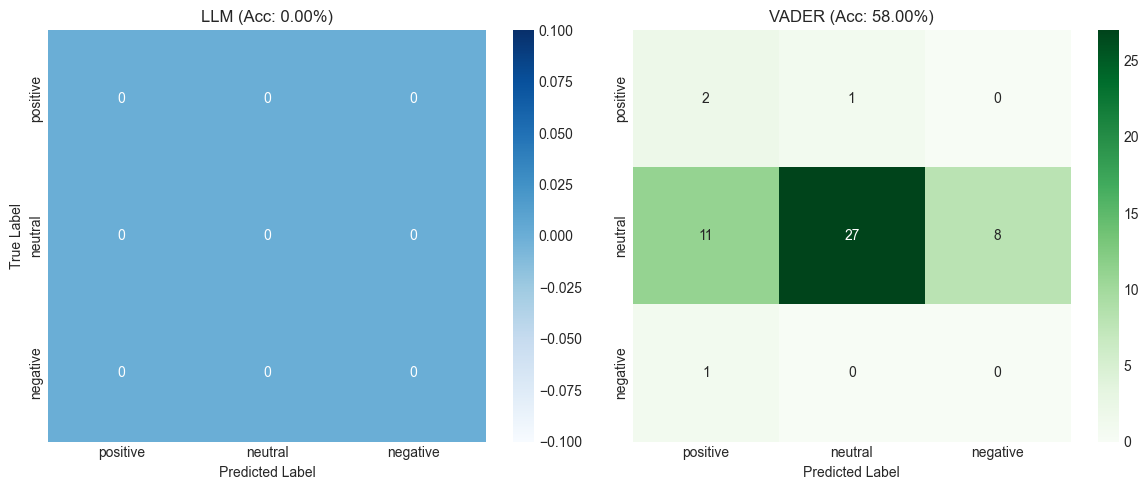

In [9]:
y_true = df_eval['manual_label']
y_llm = df_eval['llm_label']
y_vader = df_eval['vader_label']
labels = ['positive', 'neutral', 'negative']

print("--- LLM ACCURACY ---")
acc_llm = accuracy_score(y_true, y_llm)
print(f"{acc_llm:.2%}")

print("\n--- VADER ACCURACY ---")
acc_vader = accuracy_score(y_true, y_vader)
print(f"{acc_vader:.2%}")

# Visualizzazione Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_true, y_llm, labels=labels), annot=True, fmt='d', 
            xticklabels=labels, yticklabels=labels, cmap='Blues', ax=axes[0])
axes[0].set_title(f'LLM (Acc: {acc_llm:.2%})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(confusion_matrix(y_true, y_vader, labels=labels), annot=True, fmt='d', 
            xticklabels=labels, yticklabels=labels, cmap='Greens', ax=axes[1])
axes[1].set_title(f'VADER (Acc: {acc_vader:.2%})')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()